# Integration of spherically symmetric and axisymmetric TOV equations

In this notebook we perform a numerical integration of the standard TOV system of equations for the interior profile of a spherically symmetric neutron star (NS), as well as a modified version of the TOV equations proposed to describe a slightly deformed, axisymmetric NS by Zubairi and Weber (Omair Zubairi and Fridolin Weber 2017 J. Phys.: Conf. Ser. 845 012005). Parts of the code are supplemented by functions and data found in the github repository for the PYTOV project (https://github.com/dlwhittenbury/PYTOV).

This project is part of the course Theoretical and Numerical Aspects of Nuclear Physics, UNIBO, 2025.

The first part of the script reads the input equations of state (EoS) for the NS nuclear matter. We compare a quark-hadron EoS from the CompOSE database by Dexheimer et al (https://compose.obspm.fr/eos/272 : DS (CMF)-6 Hybrid with crust) and a quark-hadron EoS employed by the aforementioned authors, sampled as data points from the pressure-energy density graph, as well as an EoS obtained by the PYTOV data for approximating the low-energy region. Later on we define analytically an EoS for a relativistic Fermi gas (https://arxiv.org/abs/nucl-th/0309041). The resulting mass functions (NS mass-radius relations) for each EoS are additionally read as data (radius [km], mass [Mo]) point files.

The rest of the script contains the definition of the ToV and modified ToV (referred to as 'custom') equations as well as the fits performed on the EoS data points to obtain energy_density(pressure) functions. The fit/interpolation is performed with one of two methods chosen by parameter fit_pick (0 or 1 or 2) and the EoS is chosen by the parameter eos_pick (0 or 1 or 2 or 3 or 4). 

Integration is performed using a nested Runge-Kutta 4 algorithm on a range of NS central pressure values as well as deformation parameters to obtain the mass function for the chosen EoS. A simple Euler algorithm for the integration is additionally appended to perform quick checks and compare the integration methods.

BBKF(DD2F-SF) quark-hadron model RDF 1.7 without leptons
https://compose.obspm.fr/eos/161

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm_notebook as tqdm
import math
import os

# uncomment if you want to use spline fit
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit

### Read equation of state

The following script reads data off a set of CompOSE data files kept in a directory "current_directory/input/eos/NAME/datafile", where NAME specifies the chosen EoS (e.g. Dexheimer). It requires:
- eos.nb (baryon number density data)
- eos.t (temperature data)
- eos.yq (charge ratio data)
- eos.thermo (thermodynamic data)

in the format specified by CompOSE

https://arxiv.org/pdf/2203.03209
(CompOSE Reference Manual, II 4)

In [6]:
auth_name = 'Dexheimer'

f = open(f"input/eos/{auth_name}/eos.nb", "r")
content = f.readlines()
f.close()

nb = np.array([float(line) for line in content[2:]])   # baryon number density nb [fm^-3], T=0, Y=0
dim_nb = int(content[1])    # dimension of nb

# read dimension of T,Y 

f = open(f"input/eos/{auth_name}/eos.t", "r")
content = f.readlines()
dim_T = int(content[1])
f.close()

f = open(f"input/eos/{auth_name}/eos.yq", "r")
content = f.readlines()
dim_Y = int(content[1])
f.close()

dims = [dim_T, dim_nb, dim_Y]

In [ ]:
# read pressure and energy from .thermo

f = open(f"input/eos/{auth_name}/eos.thermo", "r")
content = f.readlines()
f.close()

# check ordering of indexing: we're interested in quantities as functions of nb

def index_check(content):
    
    for i in [0,1,2]:
        line = content[2].split()
        col_index = int(line[i])
        if col_index==2 and i==1: return 1, 1     # type 1: nb is first index
        if col_index==2 and i!=1: 
            
            for j in [0,1,2]:
                line = content[1+dims[i]].split()
                col_index = int(line[j])
                if col_index==2 and j==1: return 2, dims[i]             # type 2: nb is second index
                if col_index==2 and j!=1: return 3, dims[i]*dims[j]     # type 3: nb is third index
                
    return 'fail', 0

res, period = index_check(content)

p_nb = []   
ener_b = []

for i in range(dims[1]):
    line = content[1+i*period].split()
    
    p_nb += [float(line[3])]
    ener_b += [float(line[9])]
    
p_nb = np.array(p_nb)         # pressure divided by baryon number density p/nb (MeV)
ener_b = np.array(ener_b)     # scaled and shifted energy per baryon e/(mn*nb) - 1

mn = float(content[0].split()[0])   # neutron mass (MeV)
mp = float(content[0].split()[1])   # proton mass (MeV)

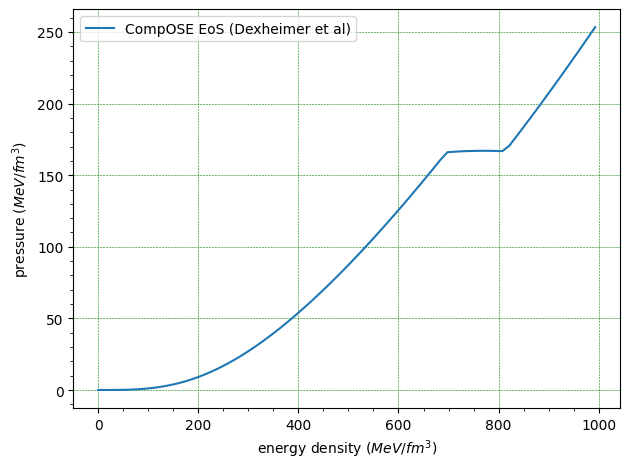

In [8]:
ener_full = mn*nb*(ener_b+1)
press_full = p_nb*nb

# restrict to region e < 1000 MeV to improve polynomial fit

i=0
for en in ener_full:
    if en >= 1000:
        cut = i
        break
    i+=1
    
ener = ener_full[:cut]
press = press_full[:cut]

ener   = np.concatenate(([1e-1],  ener), axis=None)
press  = np.concatenate(([2e-2], press), axis=None)

plt.plot(ener, press, label = f"CompOSE EoS ({auth_name} et al)")

plt.legend()
plt.xlabel("energy density $(MeV/fm^3)$")
plt.ylabel("pressure $(MeV/fm^3)$")
plt.grid(c='green', linestyle='--', linewidth = 0.4)
plt.minorticks_on()
plt.tight_layout()

#### Alternate EoS

Upload EoS file

In [12]:
# Functions obtained and modified from github PYTOV project

def join_eos(low_ener, low_press, high_ener, high_press, ener_thr):

    i1 = np.argmin(low_ener  < ener_thr)
    i2 = np.argmax(high_ener > ener_thr)

    merged_ener  = np.concatenate((low_ener[:i1],  high_ener[i2:] ))
    merged_press = np.concatenate((low_press[:i1], high_press[i2:]))

    return merged_ener, merged_press

def join_eos_PYTOV(low_density_eos: np.ndarray, high_density_eos: np.ndarray):

    i1 = np.argmax(low_density_eos[:, 0] > high_density_eos[0, 0])
    i2 = np.argmax(low_density_eos[:, 1] > high_density_eos[0, 1])
    i3 = np.argmax(low_density_eos[:, 2] > high_density_eos[0, 2])

    index = min(i1, i2, i3)

    selected_low_density_eos = low_density_eos[:index, :]
    combined_eos = np.row_stack((selected_low_density_eos, high_density_eos))

    return combined_eos

def read_eos(
    filename: str,
    order: dict[str, int] = {"density": 0, "pressure": 1, "energy_density": 2},
):
    """
    Simple EoS file reader. The eos is output in the default order density, pressure, energy density.

    filename: Filename of EoS to be read.
    order: Dictionary with keys density, pressure, energy_density and the
        values indicate which column number, e.g.,
        {"density":0, "pressure":1, "energy_density":2}.

    """

    # Paths to files
    current_dir = os.getcwd()
    INPUT_PATH = os.path.join(current_dir,f'input\eos\githubTOV')

    in_eos = np.loadtxt(os.path.join(INPUT_PATH, filename))
    eos = np.zeros(in_eos.shape)

    # Density
    eos[:, 0] = in_eos[:, order["density"]]
    eos[:, 1] = in_eos[:, order["pressure"]]
    eos[:, 2] = in_eos[:, order["energy_density"]]

    return eos

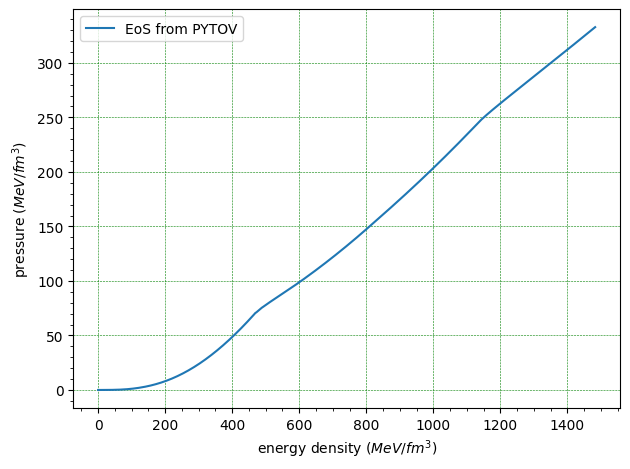

In [14]:
# from paper (Zubairi et al)
f = open(f"input/eos/Zubairi/eos_data_points.dat", "r")
content = f.readlines()
f.close()

ener_custom  = np.zeros(len(content))
press_custom = np.zeros(len(content))
i=0

for line in content:
    splt = line.split()
    ener_custom[i]  = float(splt[0].replace(',', '.'))
    press_custom[i] = float(splt[1].replace(',', '.'))
    i+=1

ener_custom   = np.concatenate(([1e-10],  ener_custom), axis=None)  # append a (0,0) point
press_custom  = np.concatenate(([1e-10], press_custom), axis=None)


# from github integrator PYTOV
low_density_eos = read_eos(filename="bps.dat")
high_density_eos = read_eos(filename="beta_eos.dat")

combined_eos = join_eos_PYTOV(low_density_eos, high_density_eos)

data = np.array(combined_eos)
n_custom1, press_custom1, ener_custom1 = data[:, 0], data[:, 1], data[:, 2] 
plt.plot(ener_custom1, press_custom1, label = f"EoS from PYTOV")

plt.legend()
plt.xlabel("energy density $(MeV/fm^3)$")
plt.ylabel("pressure $(MeV/fm^3)$")
plt.grid(c='green', linestyle='--', linewidth = 0.4)
plt.minorticks_on()
plt.tight_layout()

#### Combine PYTOV & Dexheimer

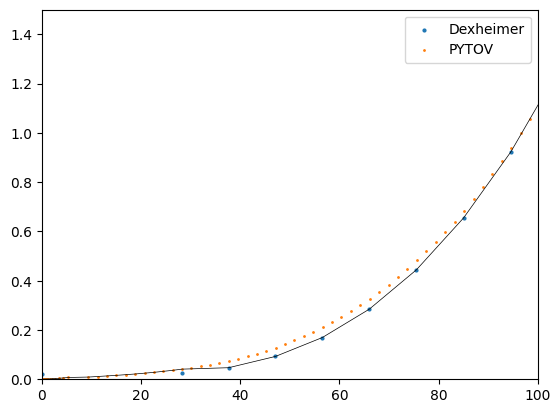

In [19]:
plt.scatter(ener,press,s=4,label='Dexheimer')
plt.scatter(ener_custom1,press_custom1,s=1,label='PYTOV')

ener_m, press_m = join_eos(ener_custom1,press_custom1,ener,press,30)

plt.plot(ener_m,press_m,c='black',linewidth=0.5)

plt.xlim(0, 100)   # x-axis from 2 to 8
plt.ylim(0, 1.5) 
plt.legend()

### Read mass functions

In [49]:
f = open(f"input/mass_func_Zubairi.txt", "r")
content = f.readlines()
f.close()

radii_paper = [[],[],[],[],[]]
masses_paper = [[],[],[],[],[]]
i=0
for line in content:
    x = float(line.split()[0].replace(',', ''))
    y = float(line.split()[1].replace(',', ''))
    if y>0:
        radii_paper[i] += [x]
        masses_paper[i] += [y]
    if y<0:
        i+=1
    
f = open(f"input/mass_func_{auth_name}.txt", "r")
content = f.readlines()
f.close()
    
radii_compose = []
masses_compose = []
for line in content:
    x = float(line.split()[0].replace(',', ''))
    y = float(line.split()[1].replace(',', ''))
    radii_compose += [x]
    masses_compose += [y]
    
f = open(f"input/mass_func_fermi.txt", "r")
content = f.readlines()
f.close()
    
radii_fermi = []
masses_fermi = []
for line in content:
    x = float(line.split()[0].replace(',', ''))
    y = float(line.split()[1].replace(',', ''))
    radii_fermi += [x]
    masses_fermi += [y]

f = open(f"input/mass_func_githubTOV.dat", "r") 
content = f.readlines()
f.close()
    
radii_git = []
masses_git = []
for line in content:
    x = float(line.split()[1])
    y = float(line.split()[2])
    radii_git += [x]
    masses_git += [y]

#### TOV integration - function definitions

In [38]:
c2 = 8.988e16*1e30           # constant c2 (fm/s)
Gc2 = 1.32e-42*c2        # constant G/c2 (fm/MeV) 
m0 = 0                   # initial mass

The axisymmetric model consists of two sets of 'ToV equations' that are integrated on the equitorial direction and the axial direction respectively, where, by assumption, the axial one differs from the equitorial by a rescaling by a factor $\gamma$ introduced as a deformation parameter. For $\gamma = 1$, there is no deformation and the equations fall back to the original ToV system.

In [39]:
def f_metric(r,m): return 1 - 2*Gc2*m/r
e0 = 3.336e3

# pressure gradient
def dpdr_equit(r, p, m): return - (Gc2/r**2) * (eps(p) + p) * (4*np.pi*(r**3)*p/(c2) + r/(2*Gc2)* (1 - f_metric(r,m)**gamma)) / f_metric(r,m)**gamma
def dpdr_axial(r, p, m): return - gamma*(Gc2/r**2) * (eps(p/gamma) + p/gamma) * (4*np.pi*(r**3)*p/(gamma*c2) + r/(2*Gc2)* (1 - f_metric(r,m)**gamma)) / f_metric(r,m)**gamma

# mass gradient 
def dmdr_equit(r, p, m): return 4*np.pi*gamma*(r**2)*eps(p) / c2
def dmdr_axial(r, p, m): return 4*np.pi*gamma*(r**2)*eps(p/gamma) / c2

# merge fit methods
def eps(p):
    
    # polynomial and spline
    if fit_pick == 0:
        if eos_pick == 0: 
            if p<50: return poly_custom(p)
            if p>=50 and p<=270: return spline_inverse_cus(p)
            else: return float("nan")
        if eos_pick == 1: 
            if p<50: return poly(p)
            if p>=50 and p<=270: return spline_inverse(p)
            else: return float("nan")
        if eos_pick == 2: return e0*(2.4216* (p/e0)**(3/5) + 2.8663* (p/e0))

    # linear and log-linear        
    if fit_pick == 1: 
        if eos_pick == 0: return linfit_cus(p)
            #if (p) < 180: return np.sqrt((p) / 0.0005)
            #else: return 600 + (825/53)*((p) - 180)
        if eos_pick == 1: return linfit(p)
        if eos_pick == 2: return e0*(2.4216* (p/e0)**(3/5) + 2.8663* (p/e0))

    # interpolation
    if fit_pick == 2:
        if eos_pick == 0: return eos_interp(p, press_custom, ener_custom)
        if eos_pick == 1: return eos_interp(p, press, ener)
        if eos_pick == 2: return e0*(2.4216* (p/e0)**(3/5) + 2.8663* (p/e0))
        if eos_pick == 3: return eos_interp(p, press_custom1, ener_custom1)
        if eos_pick == 4: return eos_interp(p, press_m, ener_m)

#### EoS interpolation function 

fit_pick = 2 (recommended)

In [41]:
# taken from TOV integration code in https://github.com/dlwhittenbury/PYTOV

def eos_interp(P, pdata, edata):

    if P < 0:
        return 0
    else:

        i = np.argmax(pdata > P)
        # Finds the index of the first p in peos > P

        if i == 0:
            return edata[0]  # No extrapolation to lower en. density/pressure used

        else:

            if i <= len(edata)-1:  # Then interpolate

                eden = edata[i - 1] * np.exp(
                    np.log(P / pdata[i - 1])
                    * np.log(edata[i - 1] / edata[i])
                    / np.log(pdata[i - 1] / pdata[i])
                )

                return eden

            else:
                return edata[-1]  # No extrapolation to higher en. density/pressure used

C:\Users\konto\AppData\Local\Temp\ipykernel_5664\2717951382.py:20: RuntimeWarning: invalid value encountered in log
  np.log(P / pdata[i - 1])
C:\Users\konto\AppData\Local\Temp\ipykernel_5664\2717951382.py:22: RuntimeWarning: invalid value encountered in log
  / np.log(pdata[i - 1] / pdata[i])


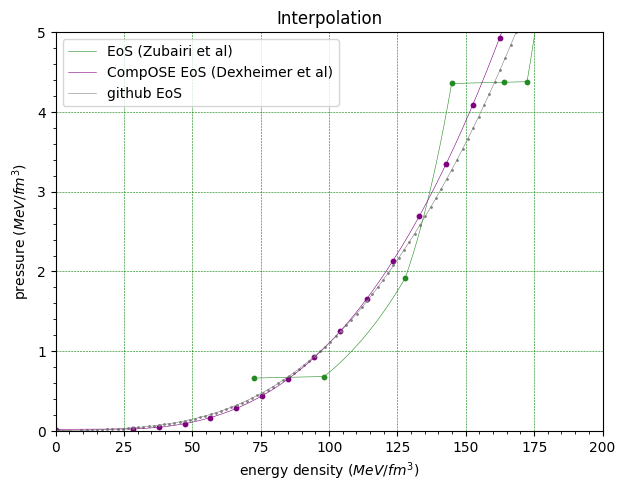

In [42]:
prange = np.linspace(0,5,2000)
fit_pick = 2

eos_pick = 0
res = []
for p in prange: res += [eps(p)]
plt.plot(res, prange, label = "EoS (Zubairi et al)", c = 'forestgreen', linewidth = 0.4)

eos_pick = 1
res = []
for p in prange: res += [eps(p)]
plt.plot(res, prange, label = f"CompOSE EoS ({auth_name} et al)", c= 'purple', linewidth = 0.4)

eos_pick = 2
res = []
for p in prange: res += [eps(p)]
#plt.plot(res, prange, label = "Fermi gas EoS", c= 'orange')

eos_pick = 3
res = []
for p in prange: res += [eps(p)]
plt.plot(res, prange, label = "github EoS", c= 'grey', linewidth = 0.4)

plt.scatter(ener, press, s=10, c = 'purple')
plt.scatter(ener_custom[0:50], press_custom[0:50], s=10, c = 'forestgreen')
plt.scatter(ener_custom1, press_custom1, s=1, c = 'grey')

plt.xlabel("energy density $(MeV/fm^3)$")
plt.ylabel("pressure $(MeV/fm^3)$")
plt.grid(c='green', linestyle='--', linewidth = 0.4)
plt.minorticks_on()
plt.tight_layout()
plt.title("Interpolation")

plt.xlim(0, 200)
plt.ylim(0, 5)
plt.legend()
plt.minorticks_on()
plt.savefig(f'output/interpol.png', bbox_inches = 'tight', dpi=300)

#### EoS fit: polynomial & spline

fit_pick = 0

We combine a polynomial fit for e(p) for small values of p (< 50) and a Sympy splice interpolation for higher values, as we find that this gives the best overall fit of our data sets. (performed on CompOSE and custom (Zubairi) input EoS)

In [27]:
# p < 50
degree = 20
coeffs        = np.polyfit(       press,        ener, degree)    # polynomial fit on CompOSE EoS data points
coeffs_custom = np.polyfit(press_custom, ener_custom, degree)    # polynomial fit on custom EoS data points
poly        = np.poly1d(coeffs)
poly_custom = np.poly1d(coeffs_custom)

# p > 50
press_sort_indices = np.argsort(press)
p_sorted = press[press_sort_indices]
e_sorted = ener[press_sort_indices]
press_cust_sort_indices = np.argsort(press_custom)
pcus_sorted = press_custom[press_cust_sort_indices]
ecus_sorted = ener_custom[press_cust_sort_indices]

spline_inverse     = UnivariateSpline(   p_sorted,    e_sorted, s=2000)
spline_inverse_cus = UnivariateSpline(pcus_sorted, ecus_sorted, s=1000)

c:\Users\konto\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\konto\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


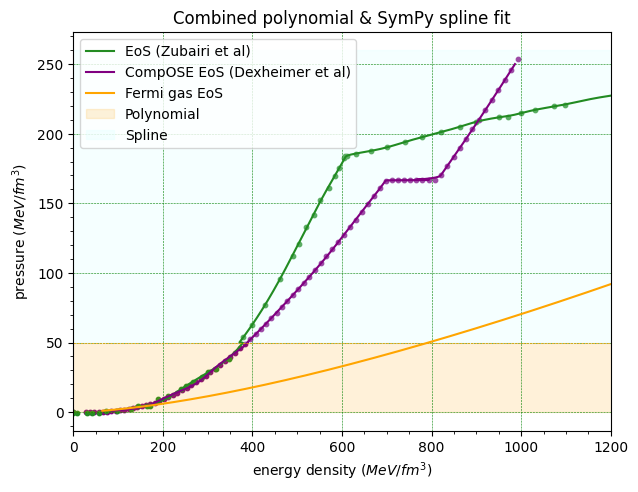

In [37]:
prange = np.linspace(1,250,1000)
fit_pick = 0

eos_pick = 0
res = []
for p in prange: res += [eps(p)]
plt.plot(res, prange, label = "EoS (Zubairi et al)", c = 'forestgreen')

eos_pick = 1
res = []
for p in prange: res += [eps(p)]
plt.plot(res, prange, label = f"CompOSE EoS ({auth_name} et al)", c= 'purple')

eos_pick = 2
res = []
for p in prange: res += [eps(p)]
plt.plot(res, prange, label = "Fermi gas EoS", c= 'orange')

plt.scatter(ener, press, s=10, c = 'purple')
plt.scatter(ener_custom[0:50], press_custom[0:50], s=10, c = 'forestgreen')

plt.xlabel("energy density $(MeV/fm^3)$")
plt.ylabel("pressure $(MeV/fm^3)$")
plt.grid(c='green', linestyle='--', linewidth = 0.4)
plt.minorticks_on()
plt.tight_layout()
plt.title("Combined polynomial & SymPy spline fit")

x = np.linspace(-100,1300,100)
plt.axhline(y=50, color='orange', linestyle="--", linewidth = 0.5)
plt.fill_between(x, 0, 50, color='orange', alpha=0.15, label = 'Polynomial')
plt.fill_between(x, 50, 260, color='lightcyan', alpha=0.3, label = 'Spline')
plt.xlim(0, 1200)

plt.legend()
plt.minorticks_on()
plt.savefig(f'output/fit_poly_spline.png', bbox_inches = 'tight', dpi=300)

#### EoS fit: log-linear & linear

fit_pick = 1

Manually split the EoS data points into groups that can be approximated either linearly or by a function $e(p) = c p^a$ and find coefficients by linear fit. (performed on CompOSE and custom (Zubairi) input EoS)

In [ ]:
# insert manually
sep_cust = [610]
sep = [690,810]

plist1,plist2,plist3,plist_cus1,plist_cus2 = [],[],[],[],[]
elist1,elist2,elist3,elist_cus1,elist_cus2 = [],[],[],[],[]

for i in range(len(ener)):
    if ener[i] <= sep[0]:
        plist1 += [press[i]]
        elist1 += [ener[i]]
    if ener[i] >= sep[0] and ener[i] <= sep[1]:
        plist2 += [press[i]]
        elist2 += [ener[i]]
    if ener[i] >= sep[1]:
        plist3 += [press[i]]
        elist3 += [ener[i]]
        
for i in range(len(ener_custom)):
    if ener_custom[i] <= sep_cust[0]:
        plist_cus1 += [press_custom[i]]
        elist_cus1 += [ener_custom[i]]
    if ener_custom[i] >= sep_cust[0] and press_custom[i] <= 237:
        plist_cus2 += [press_custom[i]]
        elist_cus2 += [ener_custom[i]]
        
plists = [plist1,plist2,plist3,plist_cus1,plist_cus2]
elists = [elist1,elist2,elist3,elist_cus1,elist_cus2]

deg = 1
coeffs_list = []

def lin_func(x, a, b): return a*x+b

for i in range(5):
    if i==1 or i==2 or i==4: coeffs_list += [np.polyfit(plists[i], elists[i], deg)]
    if i==0 or i==3: 
        cfs, _ = curve_fit(lambda x, a, b: lin_func(x, a, b), np.log10(np.array(plists[i][10:])),np.log10(np.array(elists[i][10:])), p0 = [0.5,1])
        coeffs_list += [cfs]

def poly1(p):     return 10**(coeffs_list[0][0]*np.log10(p)+coeffs_list[0][1])
def poly2(p):     return coeffs_list[1][0]*(p)+coeffs_list[1][1]
def poly3(p):     return coeffs_list[2][0]*(p)+coeffs_list[2][1]
def poly_cus1(p): return 10**(coeffs_list[3][0]*np.log10(p)+coeffs_list[3][1])
def poly_cus2(p): return coeffs_list[4][0]*(p)+coeffs_list[4][1]

psep = [166,168]
psep_cust = [186]

def linfit(p):
    if p <= psep[0]: return 10**(coeffs_list[0][0]*np.log10(p)+coeffs_list[0][1])
    if p >= psep[0] and p <= psep[1]: return coeffs_list[1][0]*(p)+coeffs_list[1][1]
    if p >=psep[1]: return coeffs_list[2][0]*(p)+coeffs_list[2][1]
    else: return float("nan")
def linfit_cus(p):
    if p <= psep_cust[0]: return 10**(coeffs_list[3][0]*np.log10(p)+coeffs_list[3][1])
    if p >= psep_cust[0]: return coeffs_list[4][0]*(p)+coeffs_list[4][1]
    else: return float("nan")

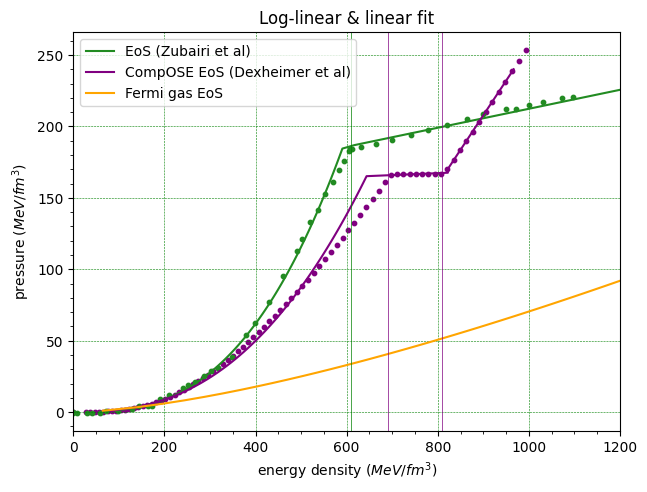

In [31]:
prange = np.linspace(1,240,100)
fit_pick = 1

eos_pick = 0
res = []
for p in prange: res += [eps(p)]
plt.plot(res, prange, label = "EoS (Zubairi et al)", c = 'forestgreen')

eos_pick = 1
res = []
for p in prange: res += [eps(p)]
plt.plot(res, prange, label = f"CompOSE EoS ({auth_name} et al)", c= 'purple')

eos_pick = 2
res = []
for p in prange: res += [eps(p)]
plt.plot(res, prange, label = "Fermi gas EoS", c= 'orange')

plt.scatter(ener, press, s=10, c = 'purple')
plt.scatter(ener_custom[0:50], press_custom[0:50], s=10, c = 'forestgreen')

plt.xlabel("energy density $(MeV/fm^3)$")
plt.ylabel("pressure $(MeV/fm^3)$")
plt.grid(c='green', linestyle='--', linewidth = 0.4)
plt.minorticks_on()
plt.tight_layout()
plt.title("Log-linear & linear fit")

plt.axvline(x=sep_cust[0], color='green', linestyle="-", linewidth = 0.5)
plt.axvline(x=sep[0], color='purple', linestyle= "-", linewidth = 0.5)
plt.axvline(x=sep[1], color='purple', linestyle="-", linewidth = 0.5)
plt.xlim(0, 1200)

plt.legend()
plt.minorticks_on()
plt.savefig(f'output/fit_log_lin.png', bbox_inches = 'tight', dpi=300)

## RK4 algorithm

In [44]:
# nested Runge-Kutta 4 algorithm
# here the arguments x0, u0 and the resulting x, u can all be vectors (n component lists) instead of scalars

def RK4(fx, fu, dt, t0, x0, u0):     # here, t -> r, x -> p, u -> m

    f1 = fx(t0, x0, u0)
    g1 = fu(t0, x0, u0)
    f2 = fx(t0 + dt/2 , x0 + (dt/2)*f1, u0 + (dt/2)*g1)
    g2 = fu(t0 + dt/2 , x0 + (dt/2)*f1, u0 + (dt/2)*g1)
    f3 = fx(t0 + dt/2 , x0 + (dt/2)*f2, u0 + (dt/2)*g2)
    g3 = fu(t0 + dt/2 , x0 + (dt/2)*f2, u0 + (dt/2)*g2)
    f4 = fx(t0 + dt, x0 + dt*f3, u0 + dt*g3)
    g4 = fu(t0 + dt, x0 + dt*f3, u0 + dt*g3)

    x = x0 + (dt/6)*(f1 + 2*f2 + 2*f3 + f4)
    u = u0 + (dt/6)*(g1 + 2*g2 + 2*g3 + g4)

    return [x,u]

# function for simulation loop. Inputs T (time span), N (number of steps), and RK4 functions fu and fx
# returns a list that includes the lists of all positions X (scalars or vectors),
# velocities U (scalars or vectors) and corresponding times t

def simul(dr_init, rmin, N, fu, fx, p0, m0):

    r = np.zeros(N)
    r[0] = rmin

    P = np.zeros(N)
    M = np.zeros(N)
    P[0] = p0
    M[0] = m0
    r_stop = 0
    epsilon = 0    # optional: stop integration at a small nonzero pressure value

    xin = p0
    uin = m0

    for i in range(N-1):

        dr = dr_init*np.exp(3*((P[i]/p0)-1))     # exponential damping of r step
        r[i+1] = r[i] + dr

        out = RK4(fx, fu, dr, r[i], xin, uin)
        xout = out[0]
        uout = out[1]
        
        if xout <= epsilon or math.isnan(xout):
            P[i+1:] = 0
            M[i+1:] = uout
            
            r_stop = r[i]
            break

        P[i+1] = xout
        M[i+1] = uout

        xin = xout
        uin = uout
    
    return P,M,r,r_stop

In [35]:
def integrate(dr_init, Rmin, N, dmdr, dpdr, P0, gamma): 
    
    m = 0
    p0 = P0
    
    Peq,M,r,r_stop  = simul(dr_init, Rmin, N, dmdr[0], dpdr[0], p0, m0)
    Pax,M,r,_ = simul(dr_init, Rmin, N, dmdr[1], dpdr[1], p0, m0)
    
    axes[0].plot(      1e-18*r,            Peq,    c = cm.cool(col), linewidth = 0.2, label = f"$\gamma = ${gamma}, $M = ${M[-1]*0.8e-60*c2:.2f} $M_\odot$")
    axes[1].plot(1e-18*r*gamma,      Pax/gamma,    c = cm.cool(col), linewidth = 0.2, label = f"$\gamma = ${gamma}, $M = ${M[-1]*0.8e-60*c2:.2f} $M_\odot$")
    axes[2].plot(      1e-18*r,   M*0.8e-60*c2,    c = cm.cool(col), linewidth = 0.2, label = f"$\gamma = ${gamma}")
    
    return Peq,Pax,M,r,r_stop*1e-18

### Run integration

Note that the number of steps N is chosen in tandem with the cut-off parameter epsilon (RK4 code cell) that serves as a threshold for the pressure below which the integration is stopped (the mass and radius at that integration step is taken to be the NS mass and radius). 

C:\Users\konto\AppData\Local\Temp\ipykernel_5664\3743602686.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for gamma in tqdm(gamma_vals):


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\konto\AppData\Local\Temp\ipykernel_5664\3743602686.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for p0 in tqdm(p0_vals):


  0%|          | 0/100 [00:00<?, ?it/s]

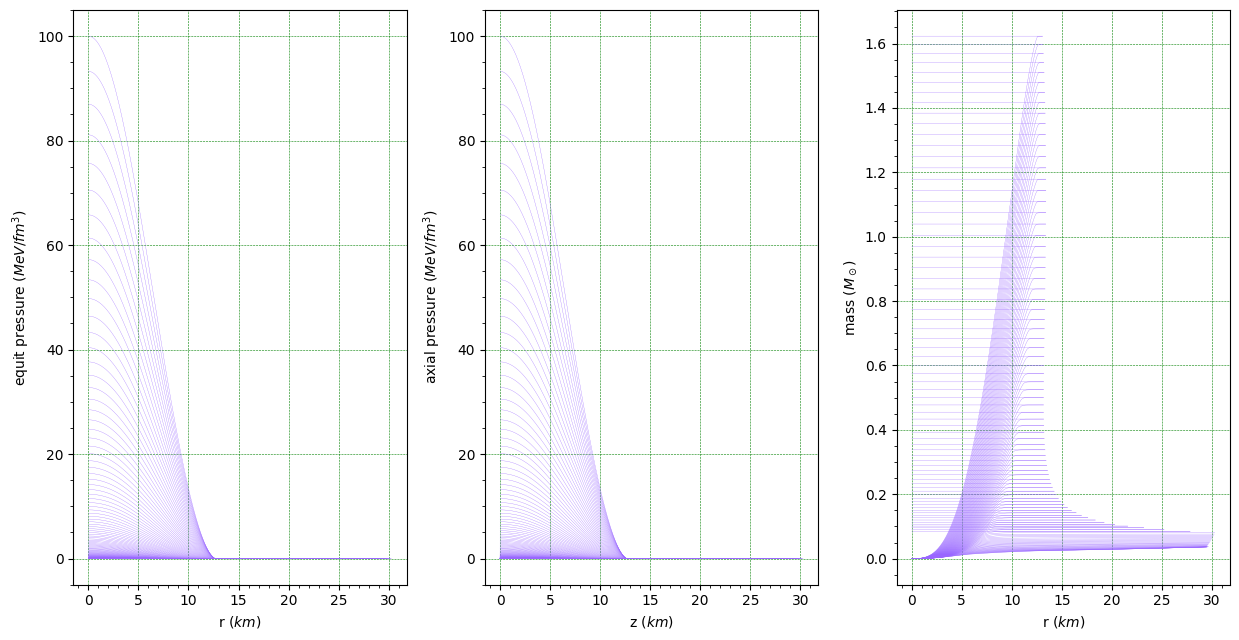

In [55]:
fig, axes = plt.subplots(1, 3, figsize=(12.5, 6.5))

# set integration limits in fm units
dr_init = 5e16
Rmin = 1e-15
# number of steps
N = 10000
gamma_vals =  [1] # np.linspace(0.8,1.2,5)
p0_vals    =    np.logspace(-1,2,100) # np.linspace(1,200,30) #

eos_pick = 4     # 0 for custom EoS, 1 for CompOSE input, 2 for Fermi gas, 3 for github (only with fit_pick=2), 4 for merged CompOSE-github (only with fit_pick=2)
fit_pick = 2     # 0 for polynomial and spline combined fit, 1 for linear on log fit, 2 for interpolation

dmdr = [dmdr_equit, dmdr_axial]
dpdr = [dpdr_equit, dpdr_axial]

R_final = np.zeros((len(gamma_vals),len(p0_vals)))
M_final = np.zeros((len(gamma_vals),len(p0_vals)))
i=0

for gamma in tqdm(gamma_vals):
    
    rtemp = []
    mtemp = []
    m=0
    
    for p0 in tqdm(p0_vals):
    
        col = 1.2*gamma-0.6
        Peq,Pax,M,r,r_stop = integrate(dr_init, Rmin, N, dmdr, dpdr, p0, gamma)
        
        for j in range(len(M)):
            if not math.isnan(M[-j-1]):
                m = M[-j-1]
                break
                
        rtemp += [r_stop]
        mtemp += [m]
    
    R_final[i] = np.array(rtemp)
    M_final[i] = np.array(mtemp)
    i+=1
        
axes[0].set_xlabel("r $(km)$")
axes[0].set_ylabel("equit pressure $(MeV/fm^3)$")
axes[0].grid(c='green', linestyle='--', linewidth = 0.4)
axes[0].minorticks_on()
#axes[0].legend()

axes[2].set_xlabel("r $(km)$")
axes[2].set_ylabel("mass $(M_\odot)$")
axes[2].grid(c='green', linestyle='--', linewidth = 0.4)
axes[2].minorticks_on()
#axes[2].legend()

axes[1].set_xlabel("z $(km)$")
axes[1].set_ylabel("axial pressure $(MeV/fm^3)$")
axes[1].grid(c='green', linestyle='--', linewidth = 0.4)
axes[1].minorticks_on()
#axes[1].legend()

plt.tight_layout()
plt.savefig(f'output/graphs{eos_pick}.png', bbox_inches = 'tight', dpi=300)

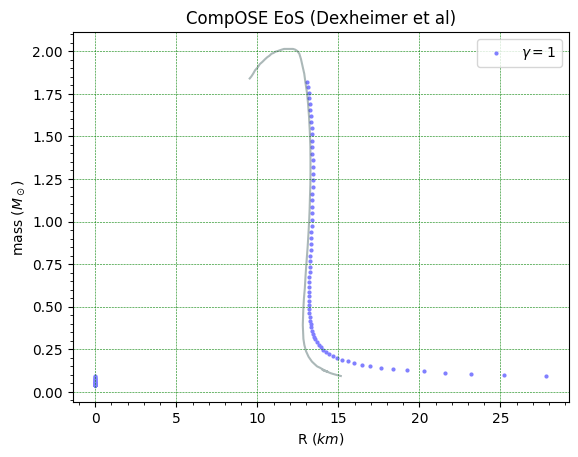

In [56]:
# Mass function

for i in range(len(gamma_vals)):
    col = 1.2*gamma_vals[i] - 0.7
    plt.scatter(R_final[i],np.array(M_final[i])*0.896e-60*c2, color = cm.cool(col), s = 4, label = f"$\gamma = ${gamma_vals[i]}")

if eos_pick == 0:
    for i in range(len(radii_paper)):
        plt.plot(np.array(radii_paper[i])*(2/3)+10, np.array(masses_paper[i]), c = 'grey', alpha= 0.5)
    plt.legend(loc = 1)
    plt.title('EoS (Zubairi et al)')
if eos_pick == 1 or eos_pick == 4:
    plt.plot(radii_compose, masses_compose, c = 'darkslategrey', alpha= 0.4)
    plt.legend(loc = 1)
    plt.title(f'CompOSE EoS ({auth_name} et al)')
if eos_pick == 2:
    plt.plot(radii_fermi, masses_fermi, c = 'darkslategrey', alpha= 0.4)
    plt.legend(loc = 1)
    plt.title('Fermi gas EoS')
if eos_pick == 3:
    plt.plot(radii_git, masses_git, c = 'darkslategrey', alpha= 0.4)
    plt.legend(loc = 1)
    plt.title('github EoS')
    
plt.xlabel("R $(km)$")
plt.ylabel("mass $(M_\odot)$")
#plt.xlim(11, 16)
#plt.ylim(0,2.2)

plt.grid(c='green', linestyle='--', linewidth = 0.4)
plt.minorticks_on()
plt.savefig(f'output/mass_function{eos_pick}.png', bbox_inches = 'tight', dpi=300)

#### Check with simple Euler

In [57]:
# Euler

def fp(p,m,r): return - (Gc2/r**2)*(eps(p)+p)*(m+4*np.pi*(r**3)*p/c2)/f_metric(r,m) 
def fm(p,m,r): return 4*np.pi*(r**2)*eps(p)/c2

In [61]:
def integ_Euler(p0,r0,N,dr):
    
    plist=[p0]
    mlist=[0]
    r=r0
    rlist = [r0]
    j=0
    
    for i in range(N):
        
        plist += [plist[-1]+dr*fp(plist[-1],mlist[-1],r)]
        mlist += [mlist[-1]+dr*fm(plist[-1],mlist[-1],r)]
        r += dr
        rlist += [r]
        if plist[-1] <= 0: 
            j=i
            break
        
    return rlist, mlist, j

C:\Users\konto\AppData\Local\Temp\ipykernel_5664\1988167378.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for p0 in tqdm(p0_vals):


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\konto\AppData\Local\Temp\ipykernel_5664\1988167378.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc = 4)


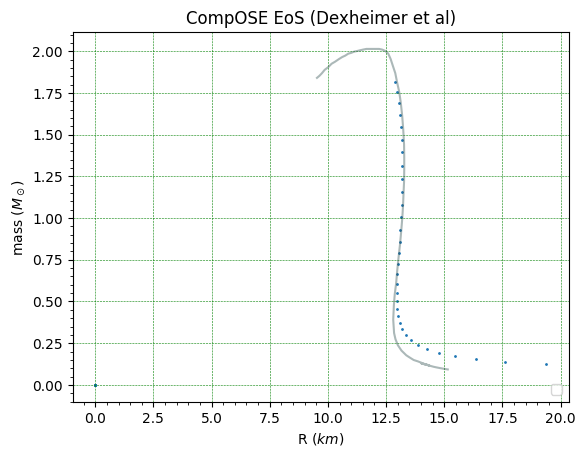

In [62]:
# set integration limits in fm units
Rmax = 2.2*1e19
Rmin = 1e-15
# number of steps
N = 1000
dr = (Rmax-Rmin)/N
p0_vals    = np.logspace(-1,2,50)

eos_pick = 4     # 0 for custom EoS, 1 for CompOSE input, 2 for Fermi gas, 3 for github (only with fit_pick=2), 4 for merged CompOSE-github (only with fit_pick=2)
fit_pick = 2     # 0 for polynomial and spline combined fit, 1 for linear on log fit, 2 for interpolation

Mlis = []
Rlis = []

for p0 in tqdm(p0_vals):
    
    x,y,z = integ_Euler(p0,Rmin,N,dr)
    Mlis += [y[z]]
    Rlis += [x[z]]
    
plt.scatter(np.array(Rlis)*1e-18,np.array(Mlis)*0.8964e-60*c2, s=1)

if eos_pick == 0:
    for i in range(len(radii_paper)):
        plt.plot(np.array(radii_paper[i])*(2/3)+10, np.array(masses_paper[i]), c = 'grey', alpha= 0.5)
    plt.legend(loc = 4)
    plt.title('EoS (Zubairi et al)')
if eos_pick == 1 or eos_pick == 4:
    plt.plot(radii_compose, masses_compose, c = 'darkslategrey', alpha= 0.4)
    plt.legend(loc = 4)
    plt.title('CompOSE EoS (Dexheimer et al)')
if eos_pick == 2:
    plt.plot(radii_fermi, masses_fermi, c = 'darkslategrey', alpha= 0.4)
    plt.legend(loc = 4)
    plt.title('Fermi gas EoS')

plt.xlabel("R $(km)$")
plt.ylabel("mass $(M_\odot)$")
plt.grid(c='green', linestyle='--', linewidth = 0.4)
plt.minorticks_on()